# Chapter 5: Quantum Annealing Linear Solvers

Introduction to quantum annealing using D-Wave systems and QUBO formulations.

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [ ]:
# Setup and imports for D-Wave
import numpy as np
import matplotlib.pyplot as plt
from pyqubo import Binary, Array,Placeholder
from dimod.reference.samplers import ExactSolver
import neal
import networkx as nx
from time import time

from Chapter03_StructuralOptimization_functions import TrussFEM, truss2x2, truss3x3
from Chapter05_RealNumberEncoding_functions import QUBOBoxSolverClass
print('Setup complete!')

Setup complete!


## QUBO Box Solver
The Box algorithm to solve a linear system of equations.

## Example to illustrate the Box algorithm

$$ \mathbf {A} \mathbf {x} = \mathbf {b} $$


$$ \mathbf {A} =  \begin{bmatrix}
            6 & -6 & 0 & 0 & 0 \\
             -6 & 12 & -6 & 0 & 0 \\
            0 & -6 & 12 & -6 & 0 \\
            0 & 0 & -6 & 12 & -6 \\
             0 & 0 & 0 & -6 & 12 \\
            \end{bmatrix} $$
$$ \mathbf {b}  = \mathbf {A} \begin{pmatrix} \pi/3 \\ -1/2 \\ 1/3 \\ \pi/10 \\ 0.1 \\0.5 \end{pmatrix} $$


In [13]:

A = np.array([[6,-6,0,0,0,0],[-6,12,-6,0,0,0],[0,-6,12,-6,0,0],[0,0,-6,12,-6,0],
		      [0,0,0,-6,12,-6],[0,0,0,0,-6,12]])
xExact = np.array([np.pi/3,-1/2,1/3,-np.pi/10,0.1,0.5 ])
b = A.dot(xExact)

QB = QUBOBoxSolverClass(
	beta=0.5,
	LBox0=1,
	tol=1e-8,
	samplingMethod="simulatedAnnealing",
	nSamples=100,
	boxMaxIteration=100
	)

xSolution, LHistory1, nIterations, _, _, _, _ = QB.QUBOBoxSolve(A, b)
print("xExact:", xExact)
print("xSolution:", xSolution)
print("*" * 50)

xExact: [ 1.04719755 -0.5         0.33333333 -0.31415927  0.1         0.5       ]
xSolution: [ 1.04736328 -0.49975586  0.33349609 -0.31396484  0.10009766  0.5       ]
**************************************************


## QUBO Truss Solver

Numpy time taken (s): 0.0001518726348876953
QUBO time taken (s): 0.8530685901641846
Error:  1.7096479868850045e-08


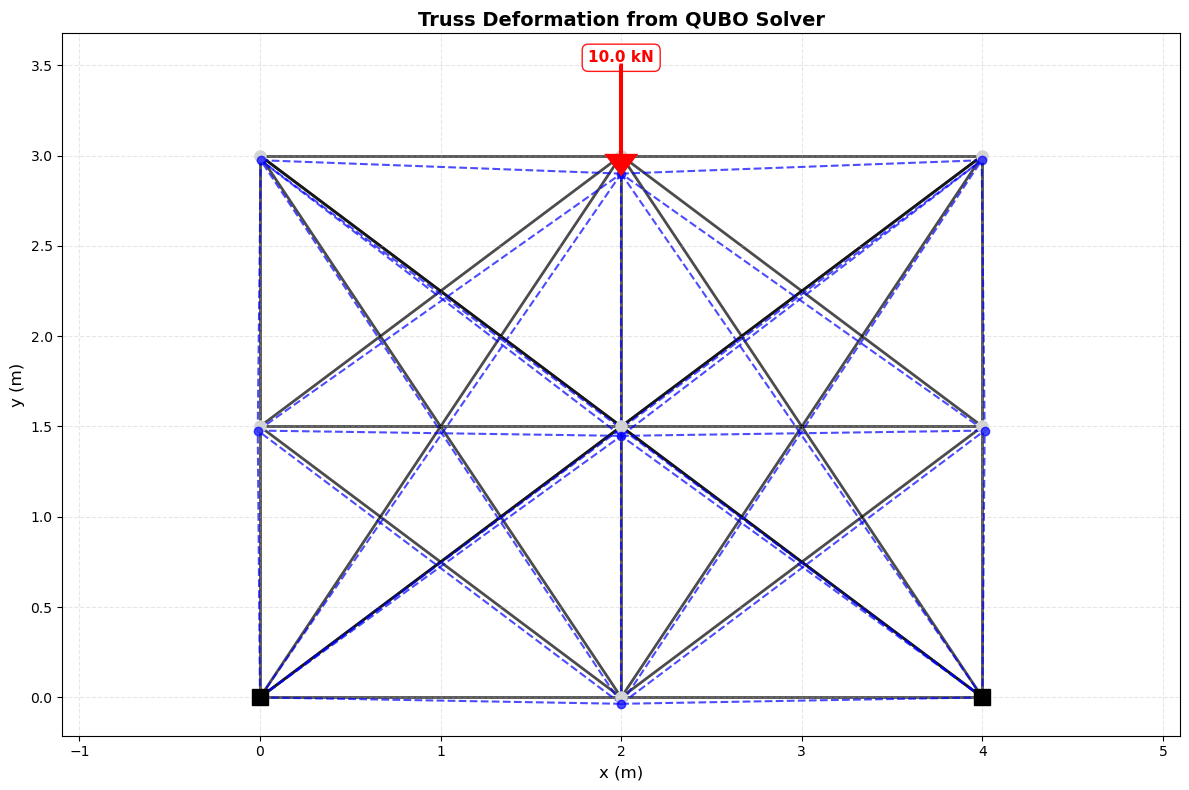

In [ ]:
fem_model= truss3x3()

K = fem_model.assemble_stiffness()
all_dofs = set(range(fem_model.n_dofs))
free_dofs = list(all_dofs - set(fem_model.fixed_dofs))
K_free = K[np.ix_(free_dofs, free_dofs)]
f_free = fem_model.loads[free_dofs]

QB = QUBOBoxSolverClass(
	beta=0.3,
	LBox0=1,
	tol=1e-8,
	samplingMethod="simulatedAnnealing",
	nSamples=100,
	boxMaxIteration=100
	)

tStart = time()
d_numpy = np.linalg.solve(K_free, f_free)
print("Numpy time taken (s):", time() - tStart)
tStart = time()
d_QUBO_free, LHistory1, nIterations, _, _, _, _ = QB.QUBOBoxSolve(K_free, f_free)
print("QUBO time taken (s):", time() - tStart)
print("Error: ", np.linalg.norm(d_numpy - d_QUBO_free))
d_QUBO = np.zeros(fem_model.n_dofs)
d_QUBO[free_dofs] = d_QUBO_free 
fem_model.plot_truss(displacements=d_QUBO,title="Truss Deformation from QUBO Solver")